In [24]:
import numpy as np
import cv2
import os
import random
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib


# Function to load images from folder, picking 2000 random images from each class

In [29]:
def load_images_from_folder(folder, num_images_per_class=2000):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if not os.path.isdir(class_folder):
            print(f"Skipping non-directory item: {class_folder}")
            continue
        all_images = os.listdir(class_folder)
        if len(all_images) < num_images_per_class:
            print(f"Not enough images in {class_folder}. Found {len(all_images)}, required {num_images_per_class}")
            continue
        selected_images = random.sample(all_images, num_images_per_class)
        for filename in selected_images:
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            img = cv2.resize(img, (256, 256))  # Resizing images to a consistent size 
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to extract color histograms

In [30]:
def extract_color_histograms(images):
    histograms = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)
    return np.array(histograms)

# Function to extract Texture Features (LBP)

In [31]:
def extract_lbp_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

# Loading images and labels

In [32]:
folder = '/Users/raghavsenwal/Downloads/data_256' 
images, labels = load_images_from_folder(folder)
print(f"Loaded {len(images)} images with {len(labels)} labels.")
print(f"Unique labels found: {set(labels)}")

Skipping non-directory item: /Users/raghavsenwal/Downloads/data_256/.DS_Store
Loaded 10000 images with 10000 labels.
Unique labels found: {'Bar', 'Gymnasium', 'HospitalRoom', 'SubwayStation ', 'Restaurant'}


# Extracting color histograms

In [33]:
X_color_hist = extract_color_histograms(images)

# Extract LBP features

In [34]:
X_lbp = extract_lbp_features(images)

# Flatten images for the classifier

In [35]:
images_flattened = images.reshape((images.shape[0], -1))

# Concatenate features with flattened pixel values

In [36]:
X_combined = np.concatenate((images_flattened, X_color_hist, X_lbp), axis=1)

# Split the data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)

# Training the Decision Tree classifier

In [38]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Predicting and evaluating the Decision Tree classifier

In [39]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Classification report and metrics

In [40]:
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 38.55%
Precision: 38.75%
Recall: 38.55%
F1 Score: 38.60%

Classification Report:
                 precision    recall  f1-score   support

           Bar       0.39      0.43      0.41       387
     Gymnasium       0.45      0.40      0.42       410
  HospitalRoom       0.41      0.40      0.40       395
    Restaurant       0.31      0.33      0.32       393
SubwayStation        0.38      0.37      0.37       415

      accuracy                           0.39      2000
     macro avg       0.39      0.39      0.39      2000
  weighted avg       0.39      0.39      0.39      2000



# Compute the confusion matrix

In [56]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[166  23  30  99  69]
 [ 35 164  81  61  69]
 [ 33  86 159  64  53]
 [110  35  57 129  62]
 [ 78  59  64  61 153]]


# Plotting the Confusion Matrix for our Decision Tree Model

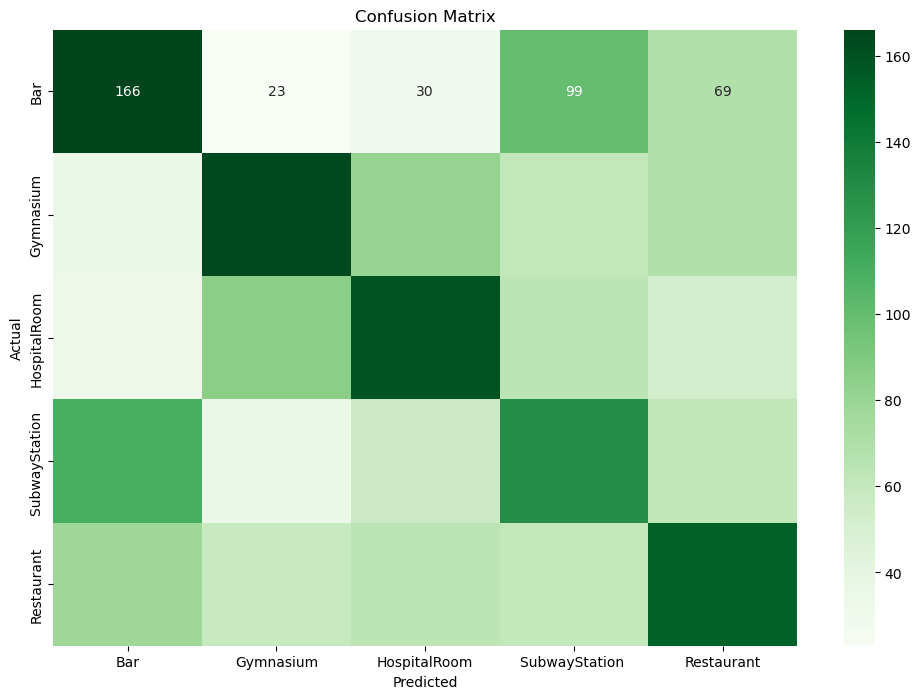

In [57]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=set(labels), yticklabels=set(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Saving the decision tree model

In [51]:
model_path = '/Users/raghavsenwal/Downloads/decision_tree_model.joblib' 
joblib.dump(clf, model_path)
print(f'Model saved to {model_path}')

Model saved to /Users/raghavsenwal/Downloads/decision_tree_model.joblib


# Loading the decision tree model 

In [52]:
loaded_clf = joblib.load(model_path)
loaded_y_pred = loaded_clf.predict(X_test)
loaded_accuracy = accuracy_score(y_test, loaded_y_pred)
print(f'Loaded Model Accuracy: {loaded_accuracy * 100:.2f}%')

Loaded Model Accuracy: 38.55%


# Training the Random Forest classifier

In [41]:
clf_rf = RandomForestClassifier(random_state=43)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

# Predict and evaluate the Random Forest Ensemble

In [42]:
y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Classification reports and metrics for Random Forest Ensemble

In [44]:
print(f'Accuracy: {accuracy_rf * 100:.2f}%')
print(f'Precision: {precision_rf * 100:.2f}%')
print(f'Recall: {recall_rf * 100:.2f}%')
print(f'F1 Score: {f1_rf * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 51.90%
Precision: 51.53%
Recall: 51.90%
F1 Score: 51.28%

Classification Report:
                 precision    recall  f1-score   support

           Bar       0.52      0.60      0.56       387
     Gymnasium       0.55      0.66      0.60       410
  HospitalRoom       0.53      0.58      0.55       395
    Restaurant       0.45      0.37      0.41       393
SubwayStation        0.52      0.39      0.45       415

      accuracy                           0.52      2000
     macro avg       0.51      0.52      0.51      2000
  weighted avg       0.52      0.52      0.51      2000



# Compute the confusion matrix

In [45]:
cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[231  19  24  71  42]
 [ 13 269  64  31  33]
 [ 20  89 229  25  32]
 [ 94  52  57 147  43]
 [ 85  60  58  50 162]]


# Plotting the Confusion Matrix for Random Forest

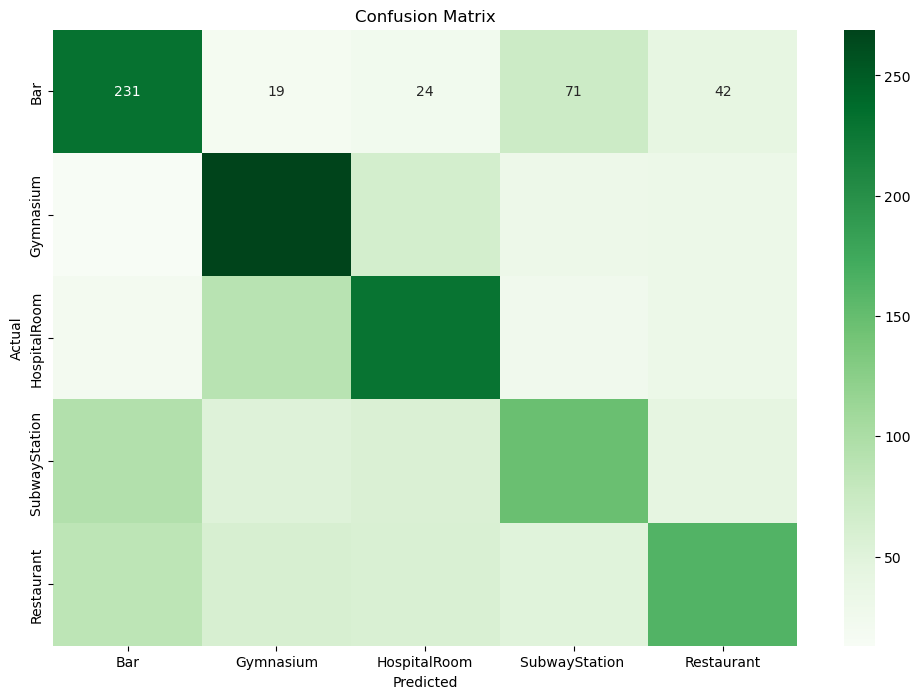

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=set(labels), yticklabels=set(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Saving the Random Forest model

In [53]:
model_path_rf = '/Users/raghavsenwal/Downloads/random_forest_model.joblib' 
joblib.dump(clf_rf, model_path_rf)
print(f'Model saved to {model_path_rf}')

Model saved to /Users/raghavsenwal/Downloads/random_forest_model.joblib


# Loading the Random Forest model from a file

In [55]:
loaded_clf = joblib.load(model_path_rf)
loaded_y_pred = loaded_clf.predict(X_test)
loaded_accuracy = accuracy_score(y_test, loaded_y_pred)
print(f'Loaded Model Accuracy: {loaded_accuracy * 100:.2f}%')

Loaded Model Accuracy: 51.90%
